[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Li-Jesse-Jiaze/multigrid-playbook/blob/main/multigrid.ipynb)

In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

%matplotlib inline

### Model Problem

1D model problem

$$
\begin{aligned}
-u_{x x} & =f \\
u(0) & =u(1)=0
\end{aligned}
$$


With finite differences

$$
\frac{-u_{i-1}+2 u_i-u_{i+1}}{h^2}=f_i \quad i=1, \ldots, n \quad u_0=u_{n+1}=0
$$


As matrix form

$$
\frac{1}{h^2}\left[\begin{array}{ccc}
2 & -1 & \\
-1 & \ddots & \ddots \\
& \ddots &
\end{array}\right] \left[\begin{array}{c}
u_1 \\
\vdots \\
u_{n}
\end{array}\right] = 
\left[\begin{array}{c}
f_1 \\
\vdots \\
f_{n}
\end{array}\right]
$$

### Use the Jacobi Method

Solve the problem
$$
A x=b
$$

Iteratively
$$
x^{(1)}=x^{(0)}+D^{-1} r^{(0)}
$$


> Or think of it as a gradient descent with
> fixed step size $1$ and preconditioner $D^{-1}$

### Some Convergence Test

The number of iterations required to get the tolerance of 1.0E-10 (RMS residual norm)

> from Burkardt, J., 2011. Jacobi Iterative Solution of Poisson’s Equation in 1D [online]

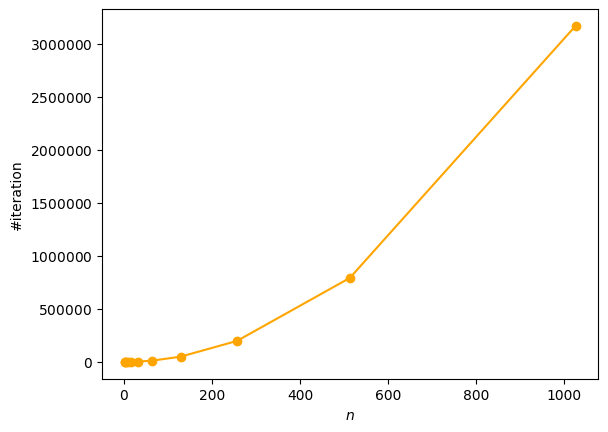

In [2]:
n_k = [2, 3, 5, 9, 17, 33, 65, 129, 257, 513, 1025]
m_k = [1, 1, 43, 188, 768, 3088, 12373, 49520, 198122, 792553, 3170329]

plt.plot(n_k, m_k, 'o-', c='orange')
plt.xlabel(r'$n$')
plt.ylabel(r'#iteration')

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

Look at the matrix
$$
A=\left[\begin{array}{ccccc}
2 & -1 & & & \\
-1 & 2 & -1 & & \\
& \ddots & \ddots & \ddots & \\
& & -1 & 2 & -1 \\
& & & -1 & 2
\end{array}\right]
$$

The eigenvalues
$$
\lambda_k=4 \sin ^2\left(\frac{k \pi}{2(n+1)}\right)
$$

The eigenvectors (are Fourier modes)

$$
\left(v_k\right)_j=\sin \left(\frac{(j+1) * k \pi}{n+1}\right)
$$

In [3]:
n = 64
A = sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n), format='csr')

# eigenvalues and eigenvectors
evals, evecs = np.linalg.eig(A.toarray())

# sort eigenvalues
eid = np.argsort(evals)
evals = evals[eid]
evecs = evecs[:,eid]

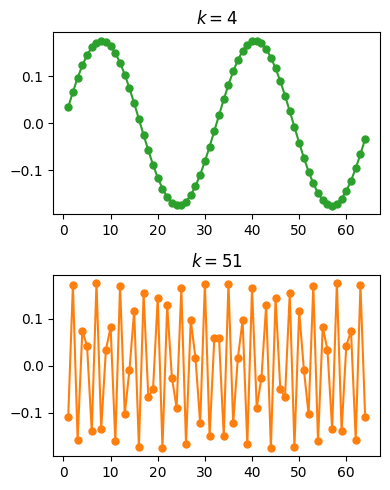

In [4]:
# x = np.linspace(0,1,n+2)[1:-1]
x = np.arange(1, n+1,)

z_evals = 4 * np.sin(np.arange(1,n+1)*np.pi / (2*(n+1)))**2
z_evecs = np.zeros((n,n))
for k in range(1,n):
    z_evecs[:,k-1] = np.sin(np.arange(1,n+1) * k * np.pi / (n+1))
    
    # also, give unit-L2 norm in length
    z_evecs[:,k-1] = z_evecs[:,k-1] / np.linalg.norm(z_evecs[:,k-1])

plt.figure(figsize=(4, 5))
plt.subplot(2, 1, 1)
plt.plot(x,evecs[:,3], 'o-', color='tab:green', ms=5)
plt.title("$k = 4$")
plt.subplot(2, 1, 2)
plt.plot(x,evecs[:,50], 'o-', color='tab:orange', ms=5)
plt.title("$k = 51$")
plt.tight_layout()

The error propagation
$$
e \leftarrow T e \quad T=I-D^{-1} A
$$

$$
T=\left[\begin{array}{ccccc}
0 & 1/2 & & & \\
1/2 & 0 & 1/2 & & \\
& \ddots & \ddots & \ddots & \\
& & 1/2 & 0 & 1/2 \\
& & & 1/2 & 0
\end{array}\right]
$$

It is averaging (mean filter)


In [5]:
n = 8
A = sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n), format='csr')
b = np.zeros((n,))

I = sparse.eye(n, format='csr')
Dinv = 0.5 * I
D = 2 * I
E = -sparse.tril(A, -1)

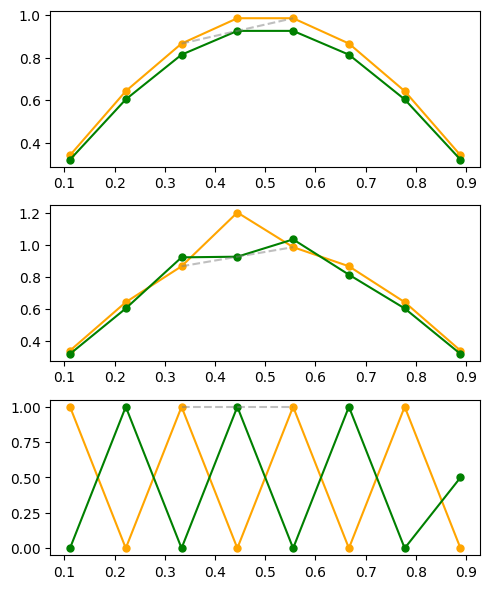

In [6]:
plt.figure(figsize=(5, 6))
plt.subplot(3, 1, 1)

x = np.linspace(0,1,n+2)[1:-1]
eold = np.sin(np.pi * x)
enew = (I - Dinv * A) * eold
plt.plot(x, eold, 'o-', color='orange', ms=5)
plt.plot(x, enew, 'o-', c='g', ms=5)
plt.plot([x[2], x[4]], [eold[2], eold[4]], '--', color='gray', alpha=.5)

plt.subplot(3, 1, 2)

x = np.linspace(0,1,n+2)[1:-1]
eold = np.sin(np.pi * x)
eold[3] = 1.2
enew = (I - Dinv * A) * eold
plt.plot(x, eold, 'o-', color='orange', ms=5)
plt.plot(x, enew, 'o-', c='g', ms=5)
plt.plot([x[2], x[4]], [eold[2], eold[4]], '--', color='gray', alpha=.5)

plt.subplot(3, 1, 3)

x = np.linspace(0,1,n+2)[1:-1]
eold = np.ones(n)
eold[1::2] = -0
enew = (I - Dinv * A) * eold
plt.plot(x, eold, 'o-', color='orange', ms=5)
plt.plot(x, enew, 'o-', c='g', ms=5)
plt.plot([x[2], x[4]], [eold[2], eold[4]], '--', color='gray', alpha=.5)

plt.tight_layout()

In [7]:
n = 64
A = sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n), format='csr')
b = np.zeros((n,))
x = np.linspace(0,1,n+2)[1:-1]
I = sparse.eye(n, format='csr')
Dinv = 0.5 * I
D = 2 * I
E = -sparse.tril(A, -1)

try
$$
u \leftarrow u + \omega D^{-1}r
$$

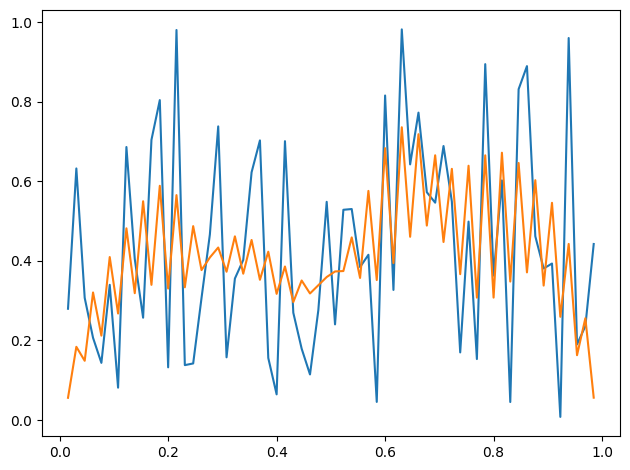

In [8]:
rnorm = []

test = 'random'

if test == 'random':
    np.random.seed(233008)
    u = np.random.rand(n)
elif test == 'smooth':
    n = A.shape[0]
    u = np.sin(np.pi * np.arange(1, n+1)/ (n+1))
    
uinit = u.copy()

for i in range(10):
    u[:] = u - 1.0 * Dinv * A * u
    #u[:] = u - sla.(D-E, A*u)
    rnorm.append(np.linalg.norm(A * u))

plt.plot(x, uinit, '-')
plt.plot(x, u, '-')
plt.tight_layout()
# plt.savefig("../slides/fig/wj1.svg")
# plt.xlabel(r'$x$')

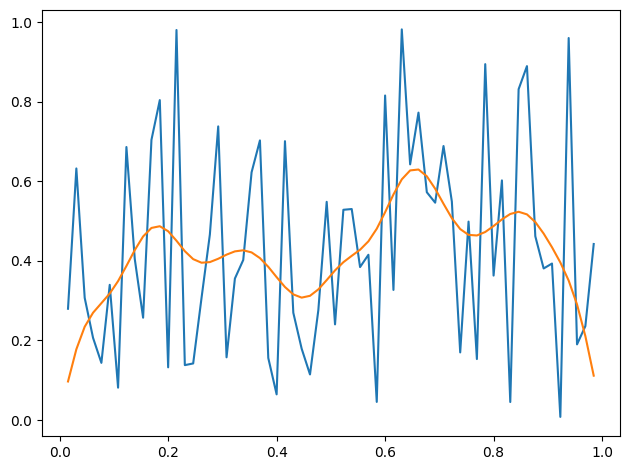

In [9]:
rnorm = []

test = 'random'

if test == 'random':
    np.random.seed(233008)
    u = np.random.rand(n)
elif test == 'smooth':
    n = A.shape[0]
    u = np.sin(np.pi * np.arange(1, n+1)/ (n+1))
    
uinit = u.copy()

for i in range(10):
    u[:] = u - 2/3 * Dinv * A * u
    #u[:] = u - sla.(D-E, A*u)
    rnorm.append(np.linalg.norm(A * u))

plt.plot(x, uinit, '-')
plt.plot(x, u, '-')
plt.tight_layout()
# plt.savefig("../slides/fig/wj1.svg")
# plt.xlabel(r'$x$')

### Fourier Analysis

Using the eigenvectors of the error propagation $T$ as a basis for the error space
$$
e^{(0)}=\sum_{k=1}^n c_k v_k
$$

Then the error transforms like
$$
e \leftarrow\left(I-\omega D^{-1} A\right) e=T e
$$

$$
e^{(\sigma)} = T e^{(0)} =\sum_{k=1}^n c_k T^\sigma v_k =\sum_{k=1}^n c_k \lambda_k^\sigma v_k
$$

Converge with the factor $\|T\|$ or $\rho(T)$


Let's observe the spectrum of
$$
G = I - \omega D^{-1} A
$$
for several $\omega$

Text(0.5, 0, '$k$')

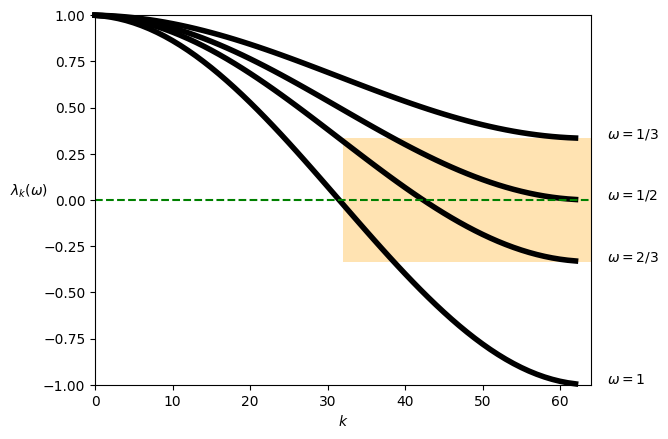

In [10]:
import matplotlib.patches as patches


fig, ax = plt.subplots()

K = np.arange(1,n)

omega = 1.0 /2
lmbda = 1 - (omega / 2) * 4.0 * np.sin(np.pi * K / (2*(n+1)))**2
plt.plot(lmbda,'-k',label='residual',linewidth=4, clip_on=False)
plt.text(n+2, lmbda[-1], r'$\omega=1/2$')

omega = 1.0 / 3.0
lmbda = 1 - (omega / 2) * 4.0 * np.sin(np.pi * K / (2*(n+1)))**2
plt.plot(lmbda,'-k',label='residual',linewidth=4, clip_on=False)
plt.text(n+2, lmbda[-1], r'$\omega=1/3$')

omega = 2.0 / 3.0
lmbda = 1 - (omega / 2) * 4.0 * np.sin(np.pi * K / (2*(n+1)))**2
plt.plot(lmbda,'-k',label='residual',linewidth=4, clip_on=False)
plt.text(n+2, lmbda[-1], r'$\omega=2/3$')

omega = 1
lmbda = 1 - (omega / 2) * 4.0 * np.sin(np.pi * K/ (2*(n+1)))**2
plt.plot(lmbda,'-k',label='residual',linewidth=4, clip_on=False)
plt.text(n+2, lmbda[-1], r'$\omega=1$')

plt.plot([0, n], [0, 0], '--g')
plt.axis([0,n,-1,1])

x0, y0   = 32, -1/3
width    = 32
height   = 2/3

rect = patches.Rectangle(
    (x0, y0), width, height,
    facecolor='orange',
    edgecolor='none',
    alpha=0.3,
    zorder=0
)

ax.add_patch(rect)

plt.ylabel(r'$\lambda_k(\omega)$', rotation=0, labelpad=10)
plt.xlabel(r'$k$')

### How can we turn low frequency errors to high frequency?

Sampling on a coarse grid

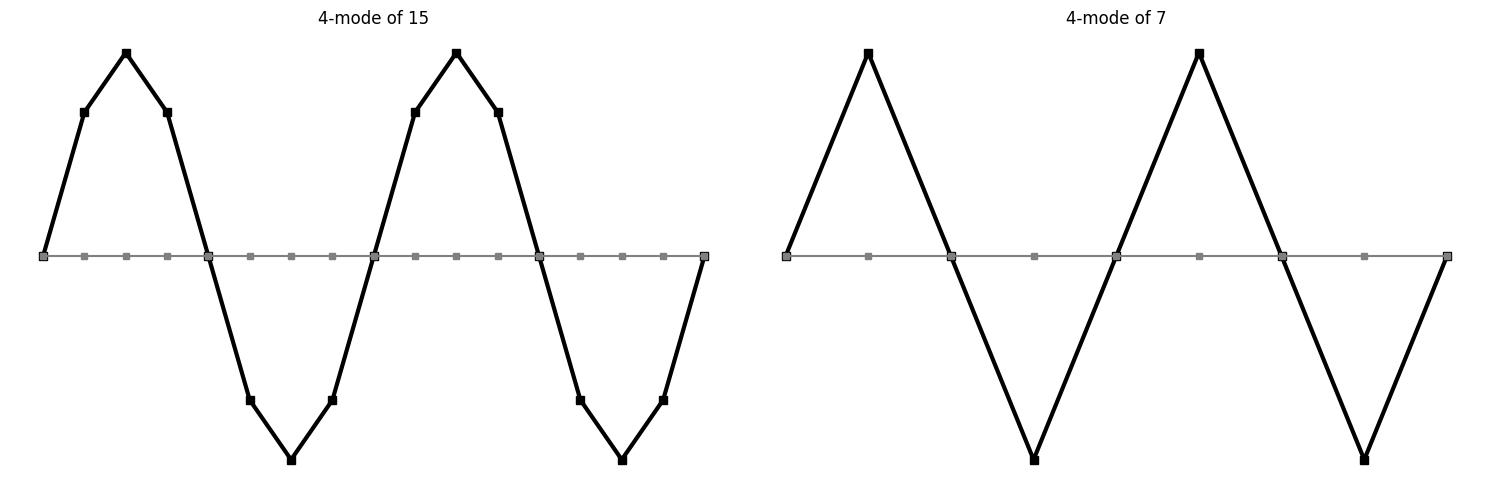

In [11]:
m = 4
k = 4

nf = 2**m + 1
xf = np.linspace(0,1,nf)
yf = np.sin(k * np.pi * xf)

nc = 2**(m-1) + 1
xc = np.linspace(0,1,nc)
yc = np.sin(k * np.pi * xc)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(xf, yf, '-s', color='k', lw=3, clip_on=False, label='fine')
plt.plot(xf, 0*xf, '-s', color='gray', ms=5)
plt.axis("off")

plt.title("4-mode of 15")
plt.subplot(1, 2, 2)
plt.plot(xc, yc, '-s', color='k', lw=3, clip_on=False, label='coarse')
plt.plot(xc, 0*xc, '-s', color='gray', ms=5)
plt.axis("off")
plt.title("4-mode of 7")
plt.tight_layout()

### Prolongation: From Coarse to Fine

Construct an operator
$$
P: \Omega^{2 h} \rightarrow \Omega^h
$$
where $\Omega^{2 h}$ is the coarse grid and $\Omega^{h}$ is the fine grid

Interpolation

$$
\begin{aligned}
v_{2 i}^h & =v_i^{2 h}\\
v_{2 i+1}^h & =\frac{1}{2}\left(v_i^{2 h}+v_{i+1}^{2 h}\right)
\end{aligned}
$$

Or in matrix form
$$
P = \frac{1}{2}\left[\begin{array}{cccc}
1 & & & \\
2 & & & \\
1 & 1 & & \\
& 2 & & \\
& & \vdots & \\
& & 1 & 1 \\
& & & 2 \\
& & & 1
\end{array}\right]
$$

In [12]:
def interpolate(vc):
    """
    linear interpolation
    
    vc : array of size 2**k - 1
    
    interpolate v of size 2**(m-1)-1 to 2**(m)-1
    """
    nc = len(vc)
    nf = 2**(int(np.log2(nc+1))+1)-1
    
    vf = np.zeros((nf,))
    
    # 1
    vf[2:-1:2] = 0.5 * vc[:-1] + 0.5 * vc[1:]
    
    # 2
    vf[1::2] = vc
    
    # 3
    vf[0] = 0.5 * vc[0]
    # 4
    vf[-1] = 0.5 * vc[-1]
    
    return vf

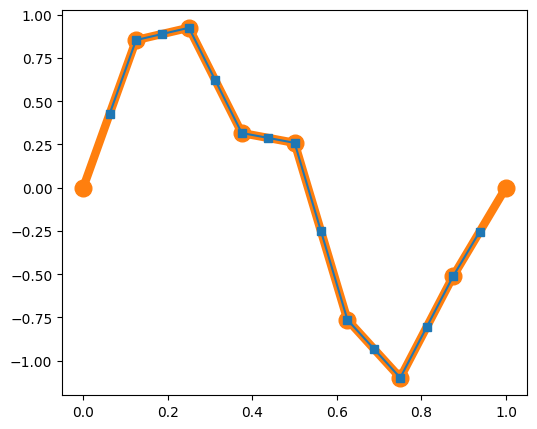

In [13]:
plt.figure(figsize=(6, 5))

m = 4
nf = 2**m - 1
nc = 2**(m-1) - 1

xc = np.linspace(0,1,nc+2)
vc = np.sin(2 * np.pi * xc)
vc[1:-1] += 0.3 * np.random.randn(len(vc[1:-1]))
# vc = np.random.rand(nc)
plt.plot(xc, vc, 'o-', color='tab:orange', clip_on=False, ms=12, lw=6)

xf = np.linspace(0,1,nf+2)[1:-1]
vf = interpolate(vc[1:-1])
#vf[0::2] += 0.5 * np.random.randn(len(vf[::2]))

plt.plot(xf, vf, 's-')

### restriction

balance pair

$$
R = P^\top = \frac{1}{2}\left[\begin{array}{cccccccccc}
1 & 2 & 1 & & & & & & & \\
& & 1 & 2 & 1 & & & & & \\
& & & & \cdots & \cdots & \cdots & & & \\
& & & & & & & 1 & 2 & 1
\end{array}\right]
$$

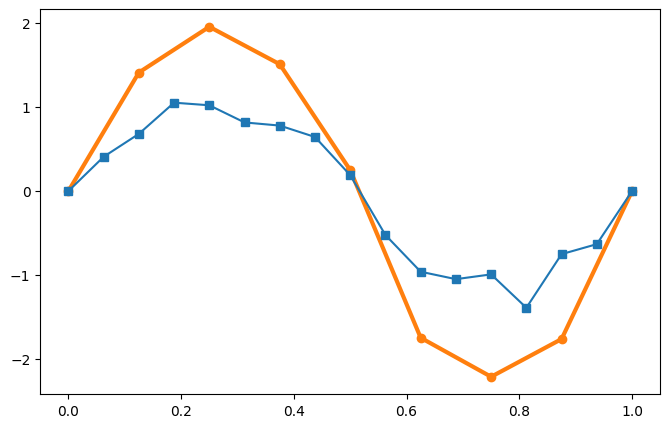

In [14]:
def restrict_full(vf):
    N  = len(vf)
    nf = N - 2
    nc = (nf + 1)//2 - 1

    vc = np.zeros(nc + 2)
    vc[0], vc[-1] = vf[0], vf[-1]
    vc[1:-1] = (0.5*vf[1:-2:2]
                +vf[2:-1:2]
                + 0.5*vf[3::2])
    return vc

m  = 4
Nf = 2**m + 1
xf = np.linspace(0, 1, Nf)
rng = np.random.default_rng(seed=0)
vf = np.sin(2*np.pi*xf)
vf[1:-1] += 0.2*rng.standard_normal(len(vf)-2)

vc = restrict_full(vf)
xc = np.linspace(0, 1, 2**(m-1)+1)

plt.figure(figsize=(8,5))
plt.plot(xc, vc, 'o-', color='tab:orange', ms=6, lw=3,
         clip_on=False)
plt.plot(xf, vf, 's-')

$\frac{1}{2}P^\top$:

$$
\frac{1}{4}\left[\begin{array}{cccccccccc}
1 & 2 & 1 & & & & & & & \\
& & 1 & 2 & 1 & & & & & \\
& & & & \cdots & \cdots & \cdots & & & \\
& & & & & & & 1 & 2 & 1
\end{array}\right]
$$

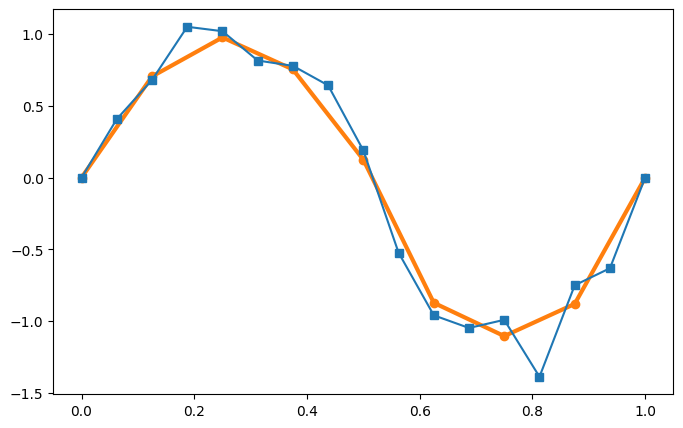

In [15]:
def restrict_full_w(vf):
    N  = len(vf)
    nf = N - 2
    nc = (nf + 1)//2 - 1

    vc = np.zeros(nc + 2)
    vc[0], vc[-1] = vf[0], vf[-1]
    vc[1:-1] = (0.25*vf[1:-2:2]
                +0.5*vf[2:-1:2]
                + 0.25*vf[3::2])
    return vc

m  = 4
Nf = 2**m + 1
xf = np.linspace(0, 1, Nf)
rng = np.random.default_rng(seed=0)
vf = np.sin(2*np.pi*xf)
vf[1:-1] += 0.2*rng.standard_normal(len(vf)-2)

vc = restrict_full_w(vf)
xc = np.linspace(0, 1, 2**(m-1)+1)

plt.figure(figsize=(8,5))
plt.plot(xc, vc, 'o-', color='tab:orange', ms=6, lw=3,
         clip_on=False)
plt.plot(xf, vf, 's-')

Injection:

$$
\left[\begin{array}{cccccccccc}
0 & 1 & 0 & & & & & & & \\
& & 0 & 1 & 0 & & & & & \\
& & & & \cdots & \cdots & \cdots & & & \\
& & & & & & & 0 & 1 & 0
\end{array}\right]
$$

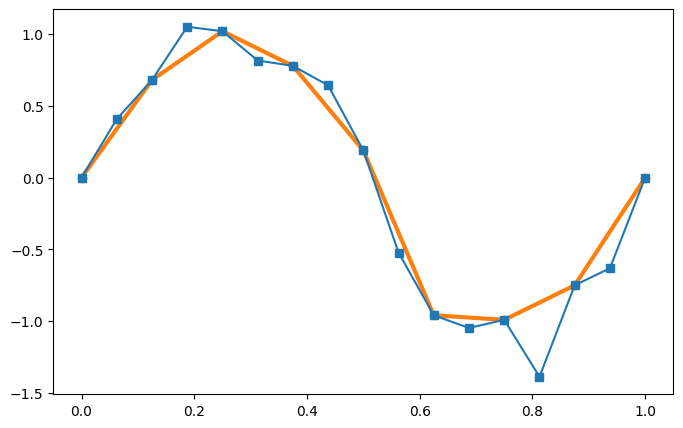

In [16]:
def restrict_full_i(vf):
    N  = len(vf)
    nf = N - 2
    nc = (nf + 1)//2 - 1

    vc = np.zeros(nc + 2)
    vc[0], vc[-1] = vf[0], vf[-1]
    vc[1:-1] = (vf[2:-1:2])
    return vc

m  = 4
Nf = 2**m + 1
xf = np.linspace(0, 1, Nf)
rng = np.random.default_rng(seed=0)
vf = np.sin(2*np.pi*xf)
vf[1:-1] += 0.2*rng.standard_normal(len(vf)-2)

vc = restrict_full_i(vf)
xc = np.linspace(0, 1, 2**(m-1)+1)

plt.figure(figsize=(8,5))
plt.plot(xc, vc, 'o-', color='tab:orange', ms=6, lw=3,
         clip_on=False)
plt.plot(xf, vf, 's-')

### Algorithm: Two-grid Method


1. Smooth $\nu_{p r e}$ times on $A u=f$
2. Compute $r=f-A u$
3. Compute $r_c=R r$
4. Solve $A_c \delta_c=r_c$
5. Interpolate $\hat{\delta}=P \delta_c$
6. Correct $u \leftarrow u+\hat{\delta}$
7. Smooth $\nu_{p o s t}$ times on $A u=f$

In [17]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

def poissonopmatrix(n):
    A = (n+1)**2 * sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n), format='csr')
    return A

def poissonop(u):
    """
    Poisson operator h^{-2} * [-1 2 1]
    Action of A * u
    """
    n = len(u)
    v = np.zeros(len(u))
    v[1:-1] = ((n+1)**2) * (2 * u[1:-1] - u[2:] - u[:-2])
    v[0]    = ((n+1)**2) * (2 * u[0]    - u[1])
    v[-1]   = ((n+1)**2) * (2 * u[-1]   - u[-2])
    return v

def residual(u, f):
    """
    f - A u
    """
    n = len(f)
    r = np.zeros(len(u))
    r[1:-1] = f[1:-1] - ((n+1)**2) * (2 * u[1:-1] - u[2:] - u[:-2])
    r[0]    = f[0]    - ((n+1)**2) * (2 * u[0]    - u[1])
    r[-1]   = f[-1]   - ((n+1)**2) * (2 * u[-1]   - u[-2])
    return r

def relax(u, f, nu):
    """
    Weighted Jacobi
    """
    n = len(u)
    Dinv = 1.0 / (2.0 * ((n+1)**2))
    omega = 2.0 / 3.0
    unew = u.copy()
    
    for steps in range(nu):
        unew = unew + omega * Dinv * residual(unew, f)
    
    return unew

def interpolate(uc):
    """interpolate u of size 2**(k-1)-1 to 2**(k)-1"""
    uf = np.zeros((2*len(uc) + 1,))
    uf[:-1:2] = 0.5 * uc
    uf[1::2] = uc
    uf[2::2] += 0.5 * uc
    return uf

def restrict(uf):
    """restrict u of size 2**(k)-1 to 2**(k-1)-1"""
    uc = 0.25 * uf[:-1:2] + 0.5 * uf[1::2] + 0.25 * uf[2::2]
    return uc

In [18]:
def vcycle2(u0, f0, nu):
    u0 = relax(u0, f0, nu)
    f1 = restrict(residual(u0, f0))
    u1 = sla.spsolve(poissonopmatrix(len(f1)), f1)    
    ui = interpolate(u1)
    u0 = u0 + ui
    u0 = relax(u0, f0, nu)
    return u0

In [19]:
def vcycle3(u, f, nu):
    f0 = f.copy()
    u0 = u.copy()
    
    u0 = relax(u0, f0, nu)
    f1 = restrict(residual(u0, f0))
    
    u1 = relax(np.zeros(len(f1)), f1, nu)
    f2 = restrict(residual(u1, f1))
    
    A2 = poissonopmatrix(len(f2))
    u2 = sla.spsolve(A2, f2)
    
    u1 += interpolate(u2)
    u1 = relax(u1, f1, 1)
    
    u0 += interpolate(u1)
    u0 = relax(u0, f0, 1)
    return u0

In [20]:
def vcycle(kmax, kmin, u, f, nu):
    """
    kmax : size of the fine grid 2**kmax -1
    kmin : size of the coarse grid 2**kmin - 1
    """
    ulist = [None for k in range(kmax+1)]
    flist = [None for k in range(kmax+1)]
    
    # down cycle
    for k in range(kmax, kmin, -1):
        u = relax(u, f, nu)
        ulist[k] = u
        flist[k] = f
        
        f = restrict(residual(u, f))
        u = np.zeros(f.shape)
        ulist[k-1] = u
        flist[k-1] = f

    # coarsest grid
    Ac = poissonopmatrix(2**kmin - 1)
    flist[kmin] = f
    ulist[kmin] = sla.spsolve(Ac, f)

    # up cycle
    for k in range(kmin+1, kmax+1, 1):
        u = ulist[k]
        f = flist[k]
        uc = ulist[k-1]
        u += interpolate(uc)
        u = relax(u, f, nu)
    return u

### Set up a problem

Here we will set up a problem on $\Omega = [0,1]$.
$$
f = 2 - 12 x^2\\
u^* = x^4 - x^2
$$
where $u^*$ will solve the problem
$$
-u'' = f
$$
In addition, from the matrix problem $A u = f$, we define
$$
u^*_d = A^{-1} f
$$

In [21]:
kmax = 5
kmin = 2

# set up fine problem
n = 2**kmax - 1

xx = np.linspace(0, 1, n+2)[1:-1]

f = 2 - 12 * xx**2

ustar = xx**4 - xx**2
A = poissonopmatrix(len(f))
udstar = sla.spsolve(A, f)
print("discretization error: ", hnorm(ustar - udstar))

discretization error:  3.1518404129513896e-05


### Things to measure

We'll measure four things in this test:
1. The residual
$$
r_k = f - A u_k
$$
2. The discretization error
$$
e = u^* - u_d^*
$$
3. The total error
$$
e = u^* - u_k
$$
4. The algebraic error
$$
e = u^*_d - u_k
$$

In [22]:
u = np.random.rand(len(f))

# set up smoothing sweeps
nu = 1

res = []
err = []
aerr = []

res.append(hnorm(residual(u, f)))
for i in range(20):
    u = vcycle(kmax, kmin, u, f, nu)
    res.append(hnorm(residual(u, f)))
    err.append(hnorm(u - ustar))
    aerr.append(hnorm(udstar - u))
    print("res = %10.4e, total err = %10.4e  alg err = %10.4e" % (res[-1], err[-1], aerr[-1]))

res = 8.7565e+00, total err = 1.2838e-02  alg err = 1.2822e-02
res = 1.4358e+00, total err = 2.9639e-03  alg err = 2.9597e-03
res = 3.5417e-01, total err = 8.1300e-04  alg err = 8.1097e-04
res = 9.9165e-02, total err = 2.2935e-04  alg err = 2.2633e-04
res = 2.8443e-02, total err = 7.1373e-05  alg err = 6.3344e-05
res = 8.1324e-03, total err = 3.6451e-05  alg err = 1.7685e-05
res = 2.3054e-03, total err = 3.1994e-05  alg err = 4.9234e-06
res = 6.4896e-04, total err = 3.1573e-05  alg err = 1.3687e-06
res = 1.8190e-04, total err = 3.1528e-05  alg err = 3.8072e-07
res = 5.0884e-05, total err = 3.1520e-05  alg err = 1.0616e-07
res = 1.4231e-05, total err = 3.1519e-05  alg err = 2.9731e-08
res = 3.9841e-06, total err = 3.1519e-05  alg err = 8.3802e-09
res = 1.1177e-06, total err = 3.1518e-05  alg err = 2.3829e-09
res = 3.1459e-07, total err = 3.1518e-05  alg err = 6.8529e-10
res = 8.8935e-08, total err = 3.1518e-05  alg err = 1.9983e-10
res = 2.5291e-08, total err = 3.1518e-05  alg err = 5.9

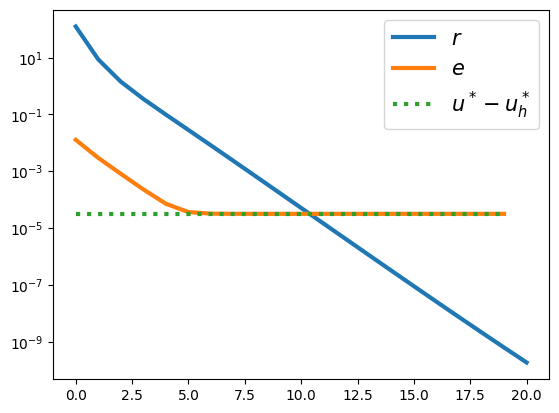

In [23]:
plt.semilogy(res, lw=3, label=r'$r$')
plt.semilogy(err, lw=3, label=r'$e$')
de = hnorm(ustar - udstar)
plt.semilogy([de for i in range(len(err))],':', lw=3, label=r'$u^*-u_h^*$')
plt.legend(fontsize=15)

The total error is limited by the discretization error

### 2D Problem

In [24]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

sten = np.zeros((3,3))
sten[[0,1,1,2],[1,0,2,1]] = -1
sten[1,1] = 4

A = stencil_grid(sten, (4,4))
print(A.toarray())

[[ 4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. 

Relaxation follows the 1D case, this time using $\omega = 4/5$.

Interpolation follws the 1D case, this time in tensor fashion.

In [25]:
def relax(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 4 / 5
    
    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)

    return unew

def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def poissonop(n):
    """
    Create a 2D operator from a stencil.
    """
    sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    A = stencil_grid(sten, (n, n))
    return A

In [26]:
n = 2**3 - 1
nc = 2**2 - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
P.toarray()

array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  ,

In [27]:
n = 2**5 - 1
nc = 2**4 - 1
A = poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

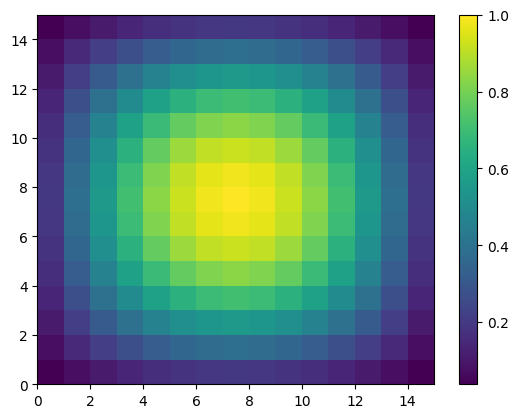

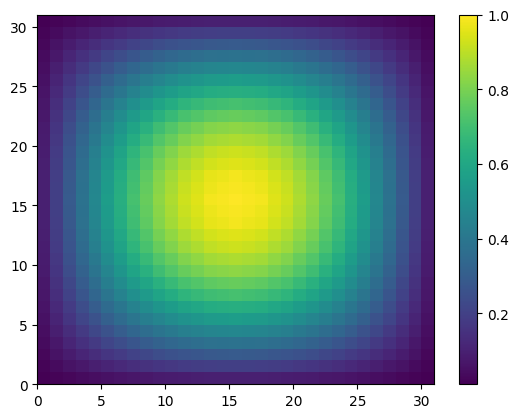

In [28]:
x1d = np.linspace(0, 1, nc+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
uc = np.sin(np.pi * X) * np.sin(np.pi * Y)
plt.figure()
plt.pcolormesh(uc)
plt.colorbar()

u = P * uc.ravel()
u = u.reshape((n,n))
plt.figure()
plt.pcolormesh(u)
plt.colorbar()

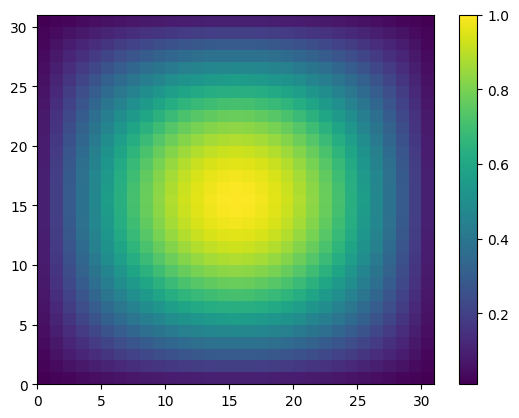

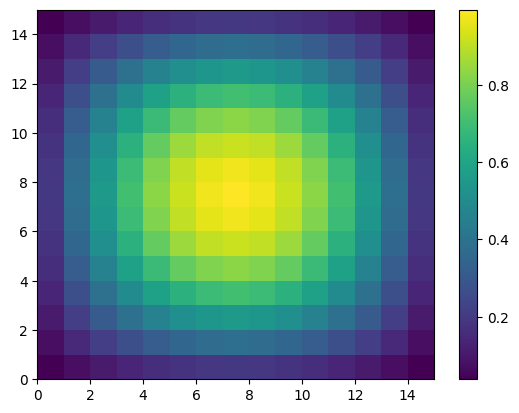

In [29]:
x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
u = np.sin(np.pi * X) * np.sin(np.pi * Y)
plt.figure()
plt.pcolormesh(u)
plt.colorbar()

uc = 0.25 * P.T * u.ravel()
uc = uc.reshape((nc,nc))
plt.figure()
plt.pcolormesh(uc)
plt.colorbar()

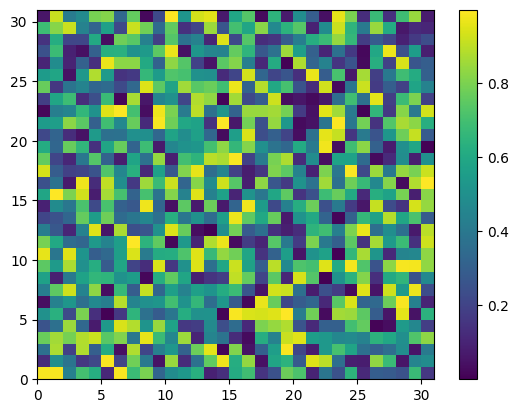

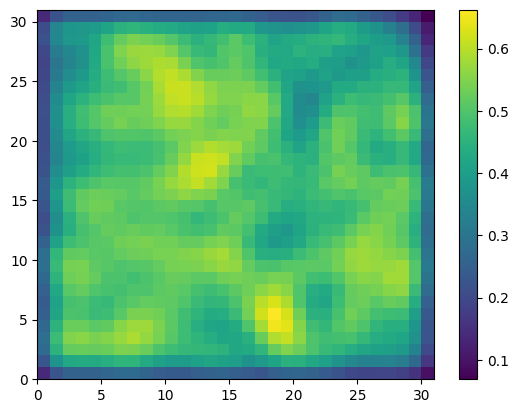

In [30]:
u = np.random.rand(n*n)
f = np.zeros((n*n,))
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()
u = relax(A, u, f, 5)
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()

Is soomthed

In [31]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

In [32]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
PT = 0.25 * P.T
u0 = np.random.rand(n*n)
f0 = np.random.rand(n*n)
print('r0=', hnorm(f0 - A * u0))

u0 = relax(A, u0, f0, 1)
f1 = PT * (f0 - A * u0)
u1 = sla.spsolve(PT * A * P, f1)
u0 = u0 + P * u1
u0 = relax(A, u0, f0, 1)
print('r1=',hnorm(f0 - A * u0))

u0 = relax(A, u0, f0, 1)
f1 = PT * (f0 - A * u0)
u1 = sla.spsolve(PT * A * P, f1)
u0 = u0 + P * u1
u0 = relax(A, u0, f0, 1)
print('r2=',hnorm(f0 - A * u0))

r0= 0.047049718277099244
r1= 0.00682779433529452
r2= 0.0016796418098648015


In [33]:
def twogrid(A, P, A1, u0, f0, nu):
    u0 = relax(A, u0, f0, nu)
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    u0 = relax(A, u0, f0, nu)
    return u0

In [34]:
k = 7
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = (n+1)**2 * poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
ustar = (X**2 - X**4) * (Y**4 - Y**2)
f = 2 * ((1-6*X**2) * Y**2 * (1 - Y**2) + (1-6*Y**2) * X**2 * (1-X**2))
f = f.ravel()
u = np.random.rand(n*n)

A1 = P.T * A * P
res = [hnorm(f - A * u)]
err = [hnorm(ustar.ravel() - u)]
for i in range(10):
    u = twogrid(A, P, A1, u, f, 1)
    res.append(hnorm(f - A * u))
    err.append(hnorm(ustar.ravel() - u))

res = np.array(res)
print(res[1:] / res[:-1])

[0.14605176 0.27049513 0.30136022 0.31643002 0.32536457 0.33122827
 0.3353599  0.33843167 0.34081125 0.34271352]
